In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

### Yet another version of the (almost) same classifier

This time, we will compare the difference between 3 classifiers: (1) fitted using only low frequencies (5-25 Hz), (2) fitted using higher frequencies (25-100 Hz) and (3) fitted using only high frequencies (70-100 Hz).

In the original article, the authors mention that:
> The features extracted are band power features for the mu and beta bands, as these frequency bands are associated with motor functions (Miller et al., 2010; Cheyne, 2013). The EEG data were band-pass filtered for the respective frequency band, and the power was calculated by squaring each time sample. Then the power was estimated in non-overlapping 0.25 s segments by averaging the power samples and applying a centered moving average with a 0.75 s window length. A centered moving average was used instead of a causal moving average in order to make the interpretation of results easier, as the latter would introduce time delays.

> High-gamma activity (70–170 Hz) was also investigated (see Supplementary material–Supplementary Figure 1 and Supplementary Tables 1, 2) as these features showed positive results in classifying individual finger movements (Liao et al., 2014). However, we did not find high-gamma activity to have any added value for visualization of activity patterns or classification.

The authors define the mu and beta bands as follows:
> mu (8–12 Hz) and beta (13–25 Hz)


**Main differences in my methodology:**
- no exact "known" band is used. Rather, the frequencies are divided using 5 Hz step increments (5-10 Hz, 10-15 Hz, and so on). As a result, mu and beta bands are divided between multiple features and sometimes overlap (mu: 5-10 Hz, 10-15 Hz; beta: 10-15 Hz, 15-20 Hz, 20-25 Hz).
- extracted features are a bit different (at least I think so). I am not sure what they calculated, I believe it is the average of the power function within the frequency bands. I calculated the area under the curve of the power function (see the `bandpower` function in `python/extract_features.py`).
- the time interval used is different. Could this be responsible for the better results?
- they created pairwise classifiers for all the fingers. Wonder why?
> Each subject’s finger movements were pairwise classified using a linear SVM, resulting in 5(5–1)/2 = 10 two-class classification problems. 


Seems like they only performed classification of the fingers, not movement vs no movement (see [Table 1](https://www.frontiersin.org/files/Articles/1009878/fnins-16-1009878-HTML-r1/image_m/fnins-16-1009878-t001.jpg)).
> Specifically, band power features during the task period (i.e., 0 to 5 s) for electrodes contained in the ROI were classified at each time step.

## Low frequency classifier

In [2]:
feature_matrix = pd.read_csv('output/problem-at-hand/S2/all/feature_matrix.csv', index_col = 0)
key = pd.read_csv('output/problem-at-hand/S2/all/key.csv')

In [3]:
def extract_feature_channel(row):
    return re.sub('X([0-9]+)_[0-9]+', '\\1', row['FeatureID'])


def extract_feature_frequency(row):
    return re.sub('X[0-9]+_([0-9]+)', '\\1', row['FeatureID'])


feature_info = pd.DataFrame(feature_matrix.index)
feature_info['Channel'] = feature_info.apply(extract_feature_channel, axis = 1)
feature_info['Frequency'] = feature_info.apply(extract_feature_frequency, axis = 1)
feature_info['Frequency'] = feature_info['Frequency'].astype('int', copy = False)

In [4]:
keep = np.where(feature_info['Frequency'] < 25)[0] # in this data, 25 Hz already corresponds to the 25-30 Hz band

feature_info = feature_info.iloc[keep, :]
feature_matrix = feature_matrix.iloc[keep, :]

assert len(feature_info) == feature_matrix.shape[0]
assert len(key) == feature_matrix.shape[1]

In [5]:
print(f'The feature matrix has {feature_matrix.shape[0]} features and {feature_matrix.shape[1]} epochs.')
print('Reminder: a feature in this case is a specific power band frequency from a specific channel,')
print('          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.')

The feature matrix has 1024 features and 8380 epochs.
Reminder: a feature in this case is a specific power band frequency from a specific channel,
          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.


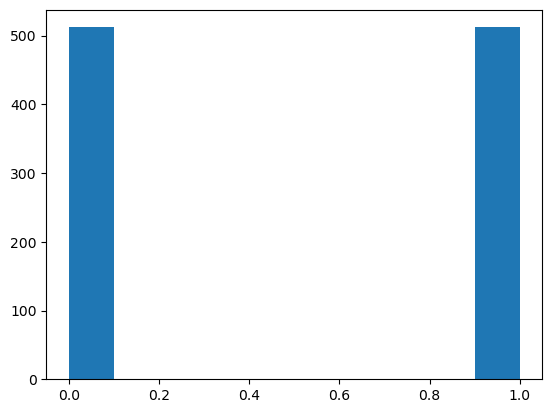

In [21]:
# Drop features with a lot of zero values
zero_percentage = np.mean(feature_matrix == 0, axis = 1)
plt.hist(zero_percentage)
plt.show()

In [29]:
keep = np.where(zero_percentage == 0)[0]

feature_info = feature_info.iloc[keep, :]
feature_matrix = feature_matrix.iloc[keep, :]

assert len(feature_info) == feature_matrix.shape[0]
assert len(key) == feature_matrix.shape[1]

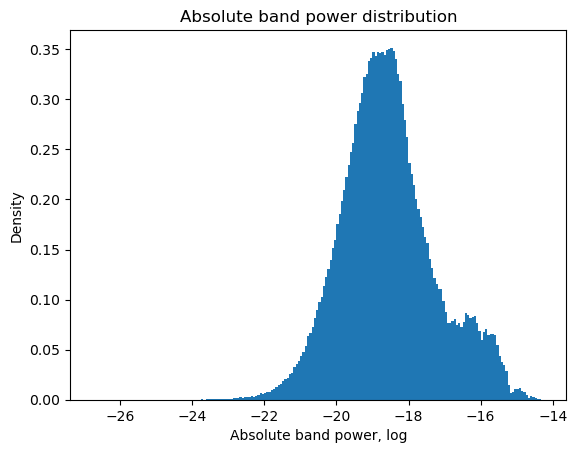

In [30]:
plt.hist(np.log(feature_matrix.values.flatten()), bins = 200, density = True)
plt.xlabel('Absolute band power, log')
plt.ylabel('Density')
plt.title('Absolute band power distribution')
plt.show()

### PCA

In [32]:
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)

In [33]:
x.shape

(8380, 512)

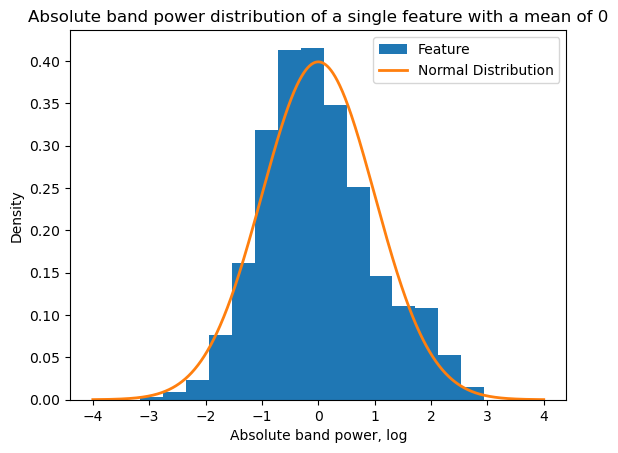

In [34]:
data = x[ :, 0 ]

mean = np.mean(data)
std_dev = np.std(data)

# Thanks to ChatGPT, we generate a normal distribution and calculate the probability density function
norm_x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
pdf_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(norm_x - mean) ** 2 / (2 * std_dev ** 2))

plt.hist(data, bins = 15, density = True, label = f'Feature')
plt.plot(norm_x, pdf_values, linewidth = 2, label = 'Normal Distribution')
plt.xlabel('Absolute band power, log')
plt.ylabel('Density')
plt.title(f'Absolute band power distribution of a single feature with a mean of {round(mean)}')
plt.legend()
plt.show()

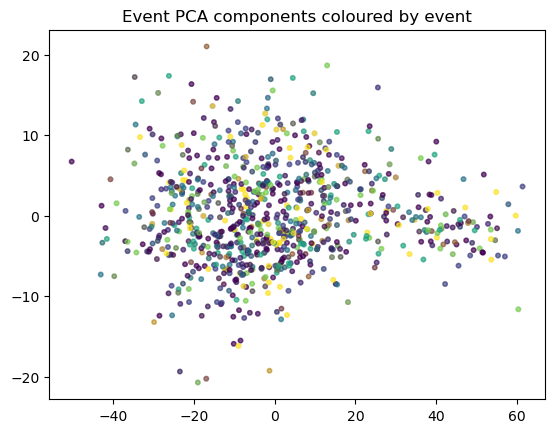

In [35]:
pca = PCA(n_components = 2).fit_transform(x)
assert pca.shape[0] == len(key)

plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Event']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by event')
plt.show()

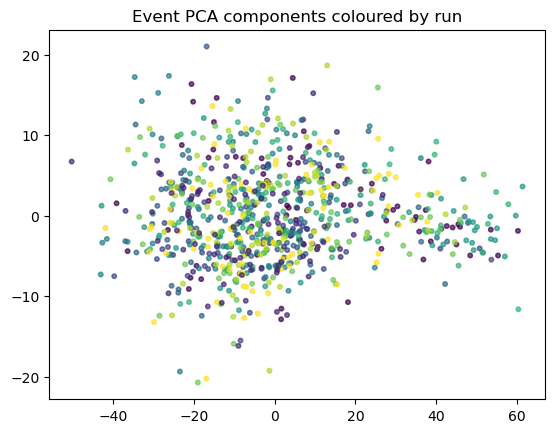

In [36]:
plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Run']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by run')
plt.show()

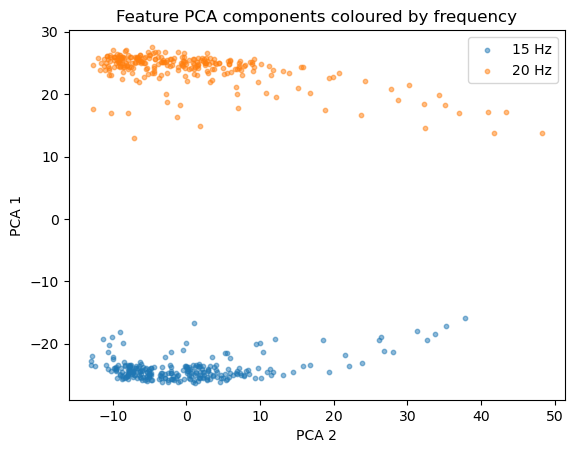

In [37]:
pca = PCA(n_components = 2).fit_transform(x.T)
assert pca.shape[0] != len(key)

for frequency in np.unique(feature_info['Frequency']):
    freq_idx = feature_info['Frequency'] == frequency
    pca_x = pca[freq_idx, 0]
    pca_y = pca[freq_idx, 1]
    plt.scatter(pca_y, pca_x,
                label = f'{frequency} Hz',
                s = 10,
                alpha = 0.5)

plt.title('Feature PCA components coloured by frequency')
plt.xlabel('PCA 2')
plt.ylabel('PCA 1')
plt.legend()
plt.show()

In [38]:
def create_splits(x, y, n_splits = 5):
    validator = StratifiedKFold(n_splits = n_splits, random_state = 42, shuffle = True)

    splits = []
    for train_ix, test_ix in validator.split(x, y):
        x_train, y_train = x[train_ix], y[train_ix]
        x_test, y_test = x[test_ix], y[test_ix]
        splits.append([x_train, y_train, x_test, y_test])

    return splits

In [39]:
def calculate_model_metrics(models, model_splits):
    model_results = []

    for model_i, split_i in zip(models, model_splits):
        train_x, train_y, test_x, test_y = split_i

        predicted_y = model_i.predict(test_x)

        model_results.append({
            'Accuracy': model_i.score(test_x, test_y),
            'TrainAccuracy': model_i.score(train_x, train_y),
            'MeanPrecisionPerClass': np.mean(precision_score(test_y, predicted_y, average = None)),
            'MeanRecallPerClass': np.mean(recall_score(test_y, predicted_y, average = None))
        })

    return pd.DataFrame(model_results)

In [40]:
# Scale the data
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)
y = LabelEncoder().fit_transform(key['Event'])

# Select only finger movement data
x = x[y != 0, :]
y = y[y != 0]

# Prepare splits
splits = create_splits(x, y)

# Calculate class weights
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes = classes, y = y)
class_weights = dict(zip(classes, class_weights))
class_weights

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}

In [41]:
#
# Grid search of the best parameters. Runs in parallel. May take a while.
#

param_grid = {
    'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
    'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]
}

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    class_weight = class_weights,
    n_jobs = 4
)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1_macro', verbose = 3, n_jobs = 2)
grid_search.fit(x, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={1: 1.0, 2: 1.0,
                                                            3: 1.0, 4: 1.0,
                                                            5: 1.0},
                                              criterion='log_loss', n_jobs=4,
                                              random_state=154),
             n_jobs=2,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]},
             scoring='f1_macro', verbose=3)

In [42]:
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']

Best set of hyperparameters:  {'max_depth': 32, 'n_estimators': 8}
Best score:  0.21204694499990487


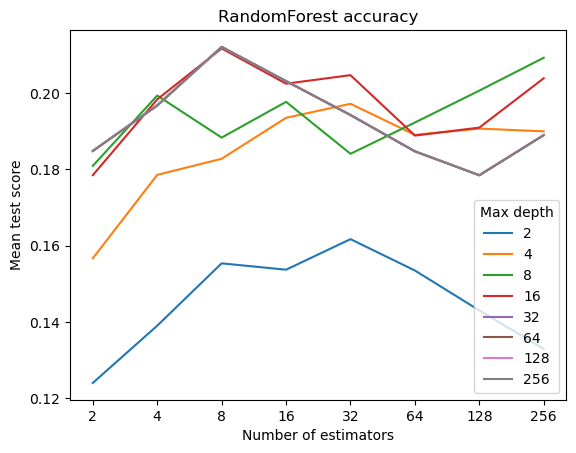

In [43]:
results = pd.DataFrame(grid_search.cv_results_)

for max_depth in np.sort(np.unique(results['param_max_depth'])):
    res = results[results['param_max_depth'] == max_depth]
    plt.plot(np.log(res['param_n_estimators'].astype(float)), res['mean_test_score'], label = max_depth)

plt.legend(title = 'Max depth')
plt.xticks(np.log([2, 4, 8, 16, 32, 64, 128, 256]), np.array([2, 4, 8, 16, 32, 64, 128, 256]))
plt.title('RandomForest accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Mean test score')
plt.show()

In [44]:
random_forest_fingers = []
for split in splits:
    print('Starting another split')
    x_train, y_train, x_test, y_test = split

    model = RandomForestClassifier(
        random_state = 154,
        criterion = 'log_loss',
        n_estimators = n_estimators,
        max_depth = max_depth,
        class_weight = class_weights,
        n_jobs = 6
    )

    model.fit(x_train, y_train)

    print(f'Model training accuracy: {model.score(x_train, y_train)}')
    print(f'Model testing accuracy: {model.score(x_test, y_test)}')

    random_forest_fingers.append(model)

Starting another split
Model training accuracy: 0.99975
Model testing accuracy: 0.99
Starting another split
Model training accuracy: 0.99925
Model testing accuracy: 0.986
Starting another split
Model training accuracy: 0.9995
Model testing accuracy: 0.987
Starting another split
Model training accuracy: 0.9995
Model testing accuracy: 0.982
Starting another split
Model training accuracy: 0.99975
Model testing accuracy: 0.986


In [45]:
random_forest_eval = calculate_model_metrics(models = random_forest_fingers, model_splits = splits)

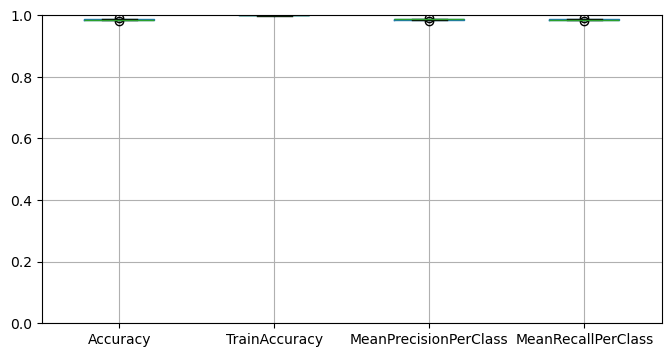

In [46]:
plt.figure(figsize = (8, 4))
random_forest_eval.boxplot()
plt.ylim(0, 1)
plt.show()

In [47]:
best_model_idx = np.argmax(random_forest_eval['Accuracy'])
model = random_forest_fingers[best_model_idx]
split = splits[best_model_idx]
x_train, y_train, x_test, y_test = split

In [48]:
print(f'Model training accuracy: {model.score(x_train, y_train)}')
print(f'Model testing accuracy: {model.score(x_test, y_test)}')

Model training accuracy: 0.99975
Model testing accuracy: 0.99


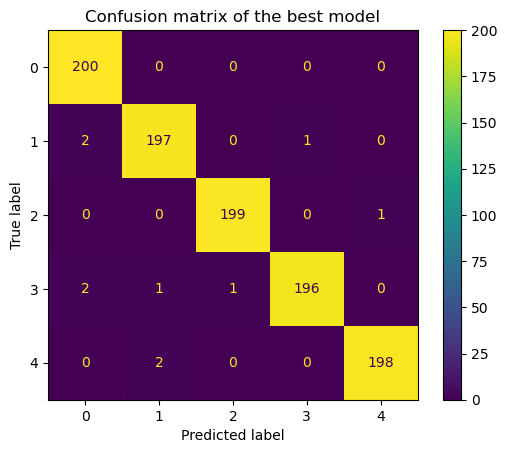

In [49]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix of the best model')
plt.show()

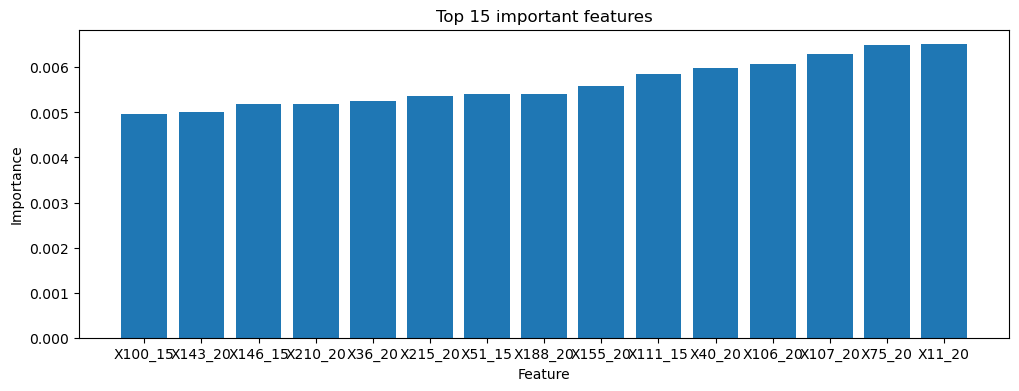

In [50]:
plt.figure(figsize = (12, 4))
importance = model.feature_importances_
forest_importance = pd.Series(importance, index = feature_matrix.index)
forest_importance = forest_importance.sort_values()

plt.bar(x = forest_importance[-15:].index, height = forest_importance[-15:])
plt.title('Top 15 important features')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

## High(er) frequency classifier

In [51]:
feature_matrix = pd.read_csv('output/problem-at-hand/S2/all/feature_matrix.csv', index_col = 0)
key = pd.read_csv('output/problem-at-hand/S2/all/key.csv')

In [52]:
def extract_feature_channel(row):
    return re.sub('X([0-9]+)_[0-9]+', '\\1', row['FeatureID'])


def extract_feature_frequency(row):
    return re.sub('X[0-9]+_([0-9]+)', '\\1', row['FeatureID'])


feature_info = pd.DataFrame(feature_matrix.index)
feature_info['Channel'] = feature_info.apply(extract_feature_channel, axis = 1)
feature_info['Frequency'] = feature_info.apply(extract_feature_frequency, axis = 1)
feature_info['Frequency'] = feature_info['Frequency'].astype('int', copy = False)

In [53]:
keep = np.where((feature_info['Frequency'] >= 25) & (feature_info['Frequency'] < 50) | (feature_info['Frequency'] >= 70))[0]

feature_info = feature_info.iloc[keep, :]
feature_matrix = feature_matrix.iloc[keep, :]

assert len(feature_info) == feature_matrix.shape[0]
assert len(key) == feature_matrix.shape[1]

In [54]:
# Drop features with a lot of zero values
zero_percentage = np.mean(feature_matrix == 0, axis = 1)
keep = np.where(zero_percentage == 0)[0]

feature_info = feature_info.iloc[keep, :]
feature_matrix = feature_matrix.iloc[keep, :]

assert len(feature_info) == feature_matrix.shape[0]
assert len(key) == feature_matrix.shape[1]

In [55]:
print(f'The feature matrix has {feature_matrix.shape[0]} features and {feature_matrix.shape[1]} epochs.')
print('Reminder: a feature in this case is a specific power band frequency from a specific channel,')
print('          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.')

The feature matrix has 1280 features and 8380 epochs.
Reminder: a feature in this case is a specific power band frequency from a specific channel,
          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.


In [58]:
# Sanity check, no lower than 25 Hz and no in range 50-65 Hz
assert set(np.unique(feature_info['Frequency'])).issubset({25, 30, 35, 40, 45, 70, 75, 80, 85, 90, 95})

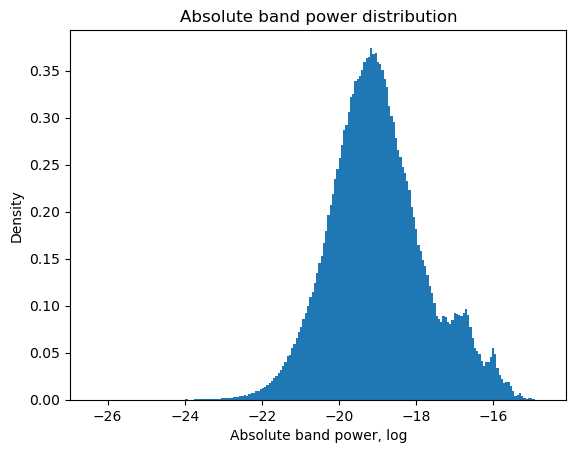

In [59]:
plt.hist(np.log(feature_matrix.values.flatten()), bins = 200, density = True)
plt.xlabel('Absolute band power, log')
plt.ylabel('Density')
plt.title('Absolute band power distribution')
plt.show()

In [60]:
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)

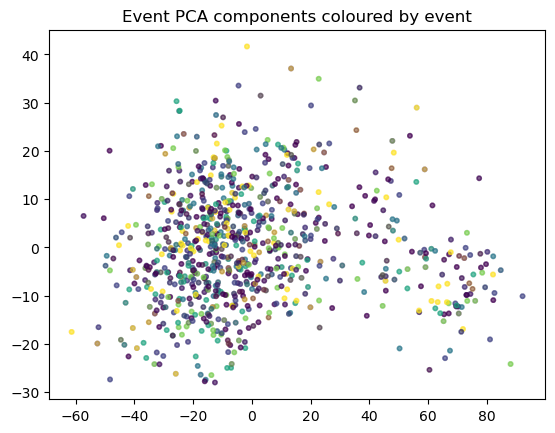

In [61]:
pca = PCA(n_components = 2).fit_transform(x)
assert pca.shape[0] == len(key)

plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Event']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by event')
plt.show()

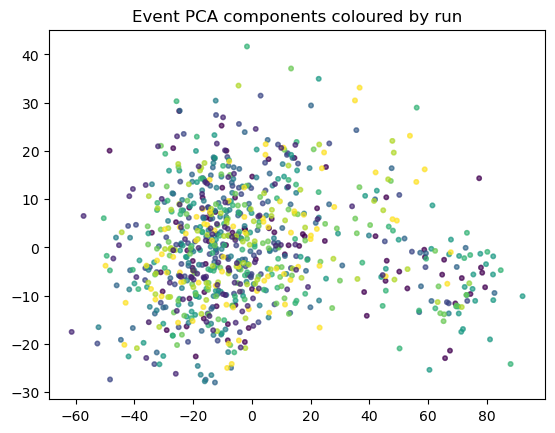

In [62]:
plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Run']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by run')
plt.show()

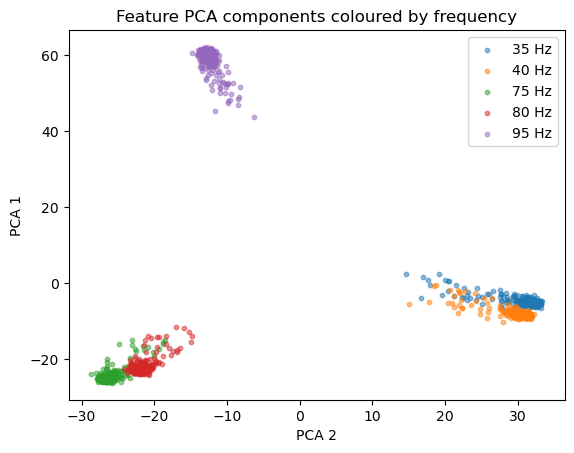

In [63]:
pca = PCA(n_components = 2).fit_transform(x.T)
assert pca.shape[0] != len(key)

for frequency in np.unique(feature_info['Frequency']):
    freq_idx = feature_info['Frequency'] == frequency
    pca_x = pca[freq_idx, 0]
    pca_y = pca[freq_idx, 1]
    plt.scatter(pca_y, pca_x,
                label = f'{frequency} Hz',
                s = 10,
                alpha = 0.5)

plt.title('Feature PCA components coloured by frequency')
plt.xlabel('PCA 2')
plt.ylabel('PCA 1')
plt.legend()
plt.show()

Interesting, 25-30 Hz and 85-90 Hz are quite close...

35 Hz, 40 Hz, 45 Hz, 75 Hz and 80 Hz form close clusters as well?..

In [64]:
# Scale the data
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)
y = LabelEncoder().fit_transform(key['Event'])

# Select only finger movement data
x = x[y != 0, :]
y = y[y != 0]

# Prepare splits
splits = create_splits(x, y)

# Calculate class weights
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes = classes, y = y)
class_weights = dict(zip(classes, class_weights))
class_weights

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}

In [65]:
#
# Grid search of the best parameters. Runs in parallel. May take a while.
#

param_grid = {
    'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
    'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]
}

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    class_weight = class_weights,
    n_jobs = 4
)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1_macro', verbose = 3, n_jobs = 2)
grid_search.fit(x, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 2/5] END .......max_depth=2, n_estimators=2;, score=0.152 total time=   0.1s
[CV 3/5] END .......max_depth=2, n_estimators=2;, score=0.122 total time=   0.1s
[CV 5/5] END .......max_depth=2, n_estimators=2;, score=0.068 total time=   0.0s
[CV 2/5] END .......max_depth=2, n_estimators=4;, score=0.165 total time=   0.1s
[CV 4/5] END .......max_depth=2, n_estimators=4;, score=0.111 total time=   0.1s
[CV 1/5] END .......max_depth=2, n_estimators=8;, score=0.172 total time=   0.1s
[CV 3/5] END .......max_depth=2, n_estimators=8;, score=0.161 total time=   0.1s
[CV 5/5] END .......max_depth=2, n_estimators=8;, score=0.139 total time=   0.1s
[CV 2/5] END ......max_depth=2, n_estimators=16;, score=0.147 total time=   0.1s
[CV 3/5] END ......max_depth=2, n_estimators=16;, score=0.146 total time=   0.1s
[CV 1/5] END ......max_depth=2, n_estimators=32;, score=0.137 total time=   0.1s
[CV 2/5] END ......max_depth=2, n_estimators=32

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={1: 1.0, 2: 1.0,
                                                            3: 1.0, 4: 1.0,
                                                            5: 1.0},
                                              criterion='log_loss', n_jobs=4,
                                              random_state=154),
             n_jobs=2,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]},
             scoring='f1_macro', verbose=3)

In [66]:
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']

Best set of hyperparameters:  {'max_depth': 4, 'n_estimators': 128}
Best score:  0.2240075494690735


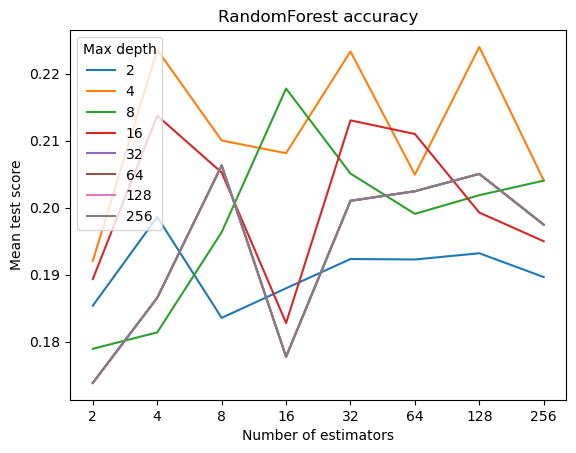

In [67]:
results = pd.DataFrame(grid_search.cv_results_)

for max_depth in np.sort(np.unique(results['param_max_depth'])):
    res = results[results['param_max_depth'] == max_depth]
    plt.plot(np.log(res['param_n_estimators'].astype(float)), res['mean_test_score'], label = max_depth)

plt.legend(title = 'Max depth')
plt.xticks(np.log([2, 4, 8, 16, 32, 64, 128, 256]), np.array([2, 4, 8, 16, 32, 64, 128, 256]))
plt.title('RandomForest accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Mean test score')
plt.show()

In [68]:
random_forest_fingers = []
for split in splits:
    print('Starting another split')
    x_train, y_train, x_test, y_test = split

    model = RandomForestClassifier(
        random_state = 154,
        criterion = 'log_loss',
        n_estimators = n_estimators,
        max_depth = max_depth,
        class_weight = class_weights,
        n_jobs = 6
    )

    model.fit(x_train, y_train)

    print(f'Model training accuracy: {model.score(x_train, y_train)}')
    print(f'Model testing accuracy: {model.score(x_test, y_test)}')

    random_forest_fingers.append(model)

Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.992
Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.991
Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.99
Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.986
Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.987


In [69]:
random_forest_eval = calculate_model_metrics(models = random_forest_fingers, model_splits = splits)

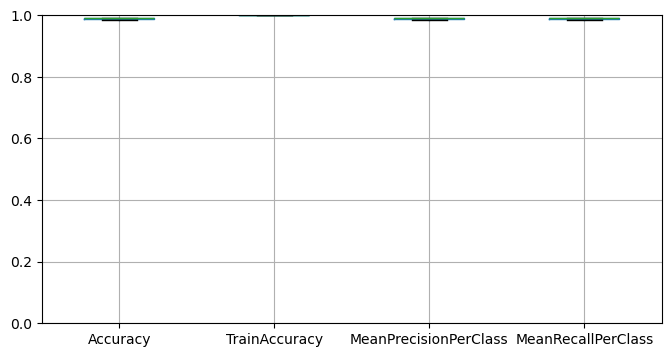

In [70]:
plt.figure(figsize = (8, 4))
random_forest_eval.boxplot()
plt.ylim(0, 1)
plt.show()

In [71]:
best_model_idx = np.argmax(random_forest_eval['Accuracy'])
model = random_forest_fingers[best_model_idx]
split = splits[best_model_idx]
x_train, y_train, x_test, y_test = split

In [72]:
print(f'Model training accuracy: {model.score(x_train, y_train)}')
print(f'Model testing accuracy: {model.score(x_test, y_test)}')

Model training accuracy: 1.0
Model testing accuracy: 0.992


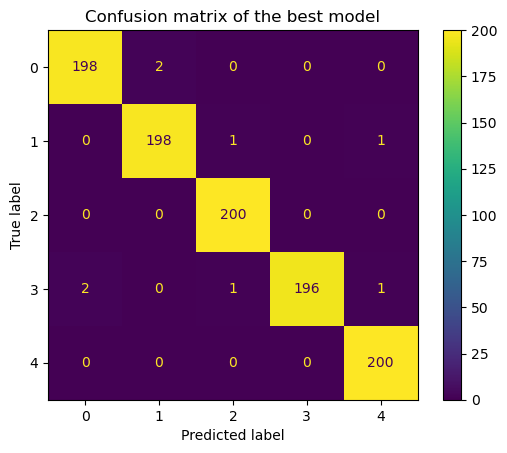

In [73]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix of the best model')
plt.show()

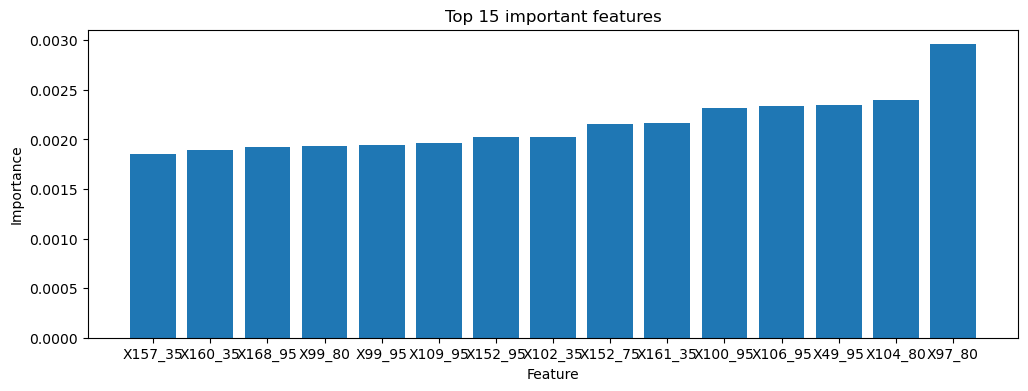

In [74]:
plt.figure(figsize = (12, 4))
importance = model.feature_importances_
forest_importance = pd.Series(importance, index = feature_matrix.index)
forest_importance = forest_importance.sort_values()

plt.bar(x = forest_importance[-15:].index, height = forest_importance[-15:])
plt.title('Top 15 important features')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

## Highest frequency classifier

In [77]:
feature_matrix = pd.read_csv('output/problem-at-hand/S2/all/feature_matrix.csv', index_col = 0)
key = pd.read_csv('output/problem-at-hand/S2/all/key.csv')

In [78]:
def extract_feature_channel(row):
    return re.sub('X([0-9]+)_[0-9]+', '\\1', row['FeatureID'])


def extract_feature_frequency(row):
    return re.sub('X[0-9]+_([0-9]+)', '\\1', row['FeatureID'])


feature_info = pd.DataFrame(feature_matrix.index)
feature_info['Channel'] = feature_info.apply(extract_feature_channel, axis = 1)
feature_info['Frequency'] = feature_info.apply(extract_feature_frequency, axis = 1)
feature_info['Frequency'] = feature_info['Frequency'].astype('int', copy = False)

In [79]:
keep = np.where(feature_info['Frequency'] >= 70)[0]

feature_info = feature_info.iloc[keep, :]
feature_matrix = feature_matrix.iloc[keep, :]

assert len(feature_info) == feature_matrix.shape[0]
assert len(key) == feature_matrix.shape[1]

In [80]:
# Drop features with a lot of zero values
zero_percentage = np.mean(feature_matrix == 0, axis = 1)
keep = np.where(zero_percentage == 0)[0]

feature_info = feature_info.iloc[keep, :]
feature_matrix = feature_matrix.iloc[keep, :]

assert len(feature_info) == feature_matrix.shape[0]
assert len(key) == feature_matrix.shape[1]

In [81]:
print(f'The feature matrix has {feature_matrix.shape[0]} features and {feature_matrix.shape[1]} epochs.')
print('Reminder: a feature in this case is a specific power band frequency from a specific channel,')
print('          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.')

The feature matrix has 768 features and 8380 epochs.
Reminder: a feature in this case is a specific power band frequency from a specific channel,
          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.


In [82]:
# Sanity check, only higher than 70
assert set(np.unique(feature_info['Frequency'])).issubset({70, 75, 80, 85, 90, 95})

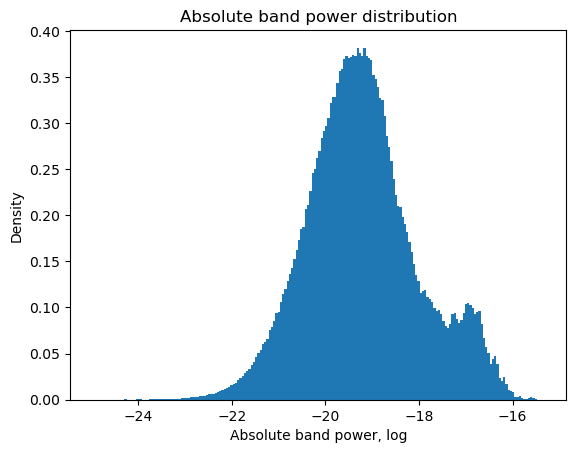

In [83]:
plt.hist(np.log(feature_matrix.values.flatten()), bins = 200, density = True)
plt.xlabel('Absolute band power, log')
plt.ylabel('Density')
plt.title('Absolute band power distribution')
plt.show()

In [84]:
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)

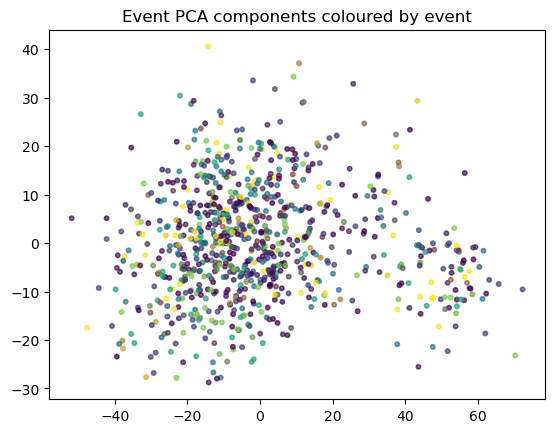

In [85]:
pca = PCA(n_components = 2).fit_transform(x)
assert pca.shape[0] == len(key)

plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Event']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by event')
plt.show()

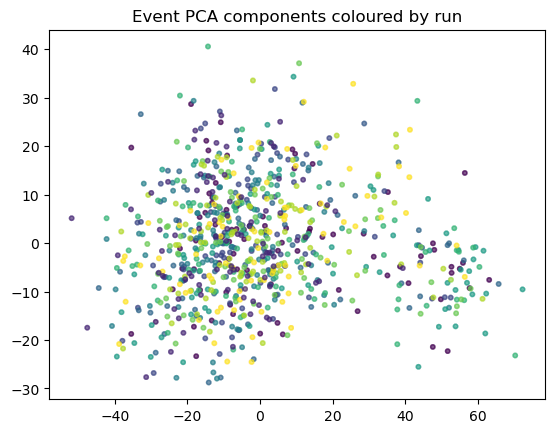

In [86]:
plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Run']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by run')
plt.show()

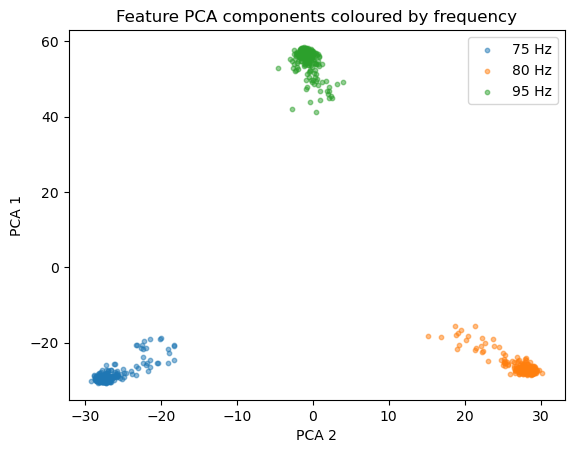

In [87]:
pca = PCA(n_components = 2).fit_transform(x.T)
assert pca.shape[0] != len(key)

for frequency in np.unique(feature_info['Frequency']):
    freq_idx = feature_info['Frequency'] == frequency
    pca_x = pca[freq_idx, 0]
    pca_y = pca[freq_idx, 1]
    plt.scatter(pca_y, pca_x,
                label = f'{frequency} Hz',
                s = 10,
                alpha = 0.5)

plt.title('Feature PCA components coloured by frequency')
plt.xlabel('PCA 2')
plt.ylabel('PCA 1')
plt.legend()
plt.show()

In [88]:
# Scale the data
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)
y = LabelEncoder().fit_transform(key['Event'])

# Select only finger movement data
x = x[y != 0, :]
y = y[y != 0]

# Prepare splits
splits = create_splits(x, y)

# Calculate class weights
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes = classes, y = y)
class_weights = dict(zip(classes, class_weights))
class_weights

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}

In [89]:
#
# Grid search of the best parameters. Runs in parallel. May take a while.
#

param_grid = {
    'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
    'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]
}

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    class_weight = class_weights,
    n_jobs = 4
)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1_macro', verbose = 3, n_jobs = 2)
grid_search.fit(x, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END .......max_depth=2, n_estimators=2;, score=0.134 total time=   0.1s
[CV 4/5] END .......max_depth=2, n_estimators=2;, score=0.145 total time=   0.1s
[CV 1/5] END .......max_depth=2, n_estimators=4;, score=0.178 total time=   0.0s
[CV 3/5] END .......max_depth=2, n_estimators=4;, score=0.158 total time=   0.1s
[CV 5/5] END .......max_depth=2, n_estimators=4;, score=0.084 total time=   0.1s
[CV 2/5] END .......max_depth=2, n_estimators=8;, score=0.147 total time=   0.1s
[CV 4/5] END .......max_depth=2, n_estimators=8;, score=0.157 total time=   0.1s
[CV 1/5] END ......max_depth=2, n_estimators=16;, score=0.136 total time=   0.1s
[CV 4/5] END ......max_depth=2, n_estimators=16;, score=0.169 total time=   0.1s
[CV 5/5] END ......max_depth=2, n_estimators=16;, score=0.171 total time=   0.1s
[CV 3/5] END ......max_depth=2, n_estimators=32;, score=0.162 total time=   0.1s
[CV 4/5] END ......max_depth=2, n_estimators=32

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={1: 1.0, 2: 1.0,
                                                            3: 1.0, 4: 1.0,
                                                            5: 1.0},
                                              criterion='log_loss', n_jobs=4,
                                              random_state=154),
             n_jobs=2,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]},
             scoring='f1_macro', verbose=3)

In [90]:
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']

Best set of hyperparameters:  {'max_depth': 32, 'n_estimators': 64}
Best score:  0.24459211204788925


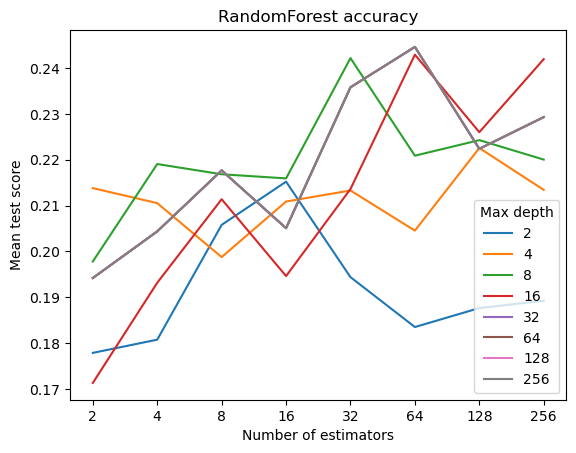

In [91]:
results = pd.DataFrame(grid_search.cv_results_)

for max_depth in np.sort(np.unique(results['param_max_depth'])):
    res = results[results['param_max_depth'] == max_depth]
    plt.plot(np.log(res['param_n_estimators'].astype(float)), res['mean_test_score'], label = max_depth)

plt.legend(title = 'Max depth')
plt.xticks(np.log([2, 4, 8, 16, 32, 64, 128, 256]), np.array([2, 4, 8, 16, 32, 64, 128, 256]))
plt.title('RandomForest accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Mean test score')
plt.show()

In [92]:
random_forest_fingers = []
for split in splits:
    print('Starting another split')
    x_train, y_train, x_test, y_test = split

    model = RandomForestClassifier(
        random_state = 154,
        criterion = 'log_loss',
        n_estimators = n_estimators,
        max_depth = max_depth,
        class_weight = class_weights,
        n_jobs = 6
    )

    model.fit(x_train, y_train)

    print(f'Model training accuracy: {model.score(x_train, y_train)}')
    print(f'Model testing accuracy: {model.score(x_test, y_test)}')

    random_forest_fingers.append(model)

Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.99
Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.99
Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.99
Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.981
Starting another split
Model training accuracy: 1.0
Model testing accuracy: 0.985


In [93]:
random_forest_eval = calculate_model_metrics(models = random_forest_fingers, model_splits = splits)

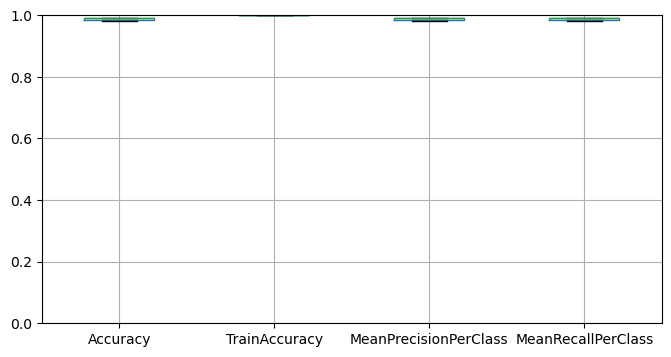

In [94]:
plt.figure(figsize = (8, 4))
random_forest_eval.boxplot()
plt.ylim(0, 1)
plt.show()

In [95]:
best_model_idx = np.argmax(random_forest_eval['Accuracy'])
model = random_forest_fingers[best_model_idx]
split = splits[best_model_idx]
x_train, y_train, x_test, y_test = split

In [96]:
print(f'Model training accuracy: {model.score(x_train, y_train)}')
print(f'Model testing accuracy: {model.score(x_test, y_test)}')

Model training accuracy: 1.0
Model testing accuracy: 0.99


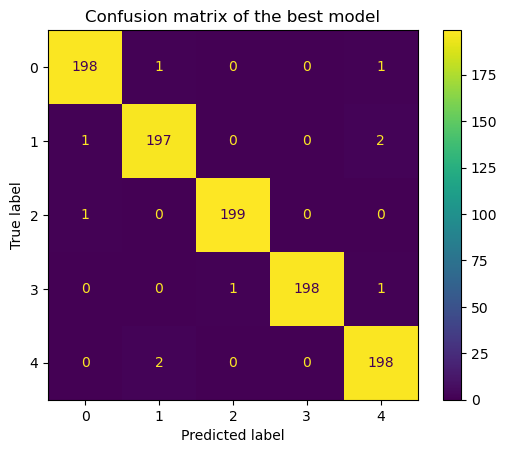

In [97]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix of the best model')
plt.show()

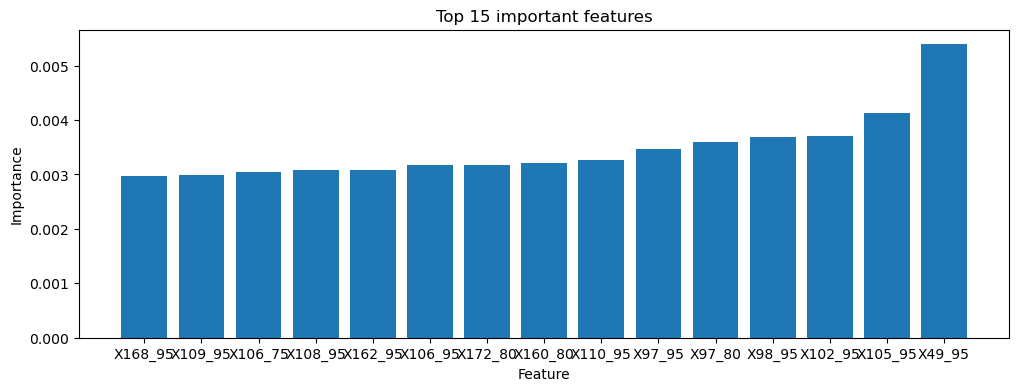

In [98]:
plt.figure(figsize = (12, 4))
importance = model.feature_importances_
forest_importance = pd.Series(importance, index = feature_matrix.index)
forest_importance = forest_importance.sort_values()

plt.bar(x = forest_importance[-15:].index, height = forest_importance[-15:])
plt.title('Top 15 important features')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()